In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import interpolate

## Bộ dữ liệu kênh truyền

Mô hình kênh truyền vô tuyến được chọn là mô hình Vehicular-A, với:
- Tần số sóng mang 2.1 GHz
- Băng thông 1.6 MHz
- Tốc độ thiết bị người dùng là 50 km/h.

Mô hình kênh truyền bao gồm 3 bộ dữ liệu:
- Đáp ứng kênh truyền lý tưởng
- Đáp ứng kênh truyền nhiễu với SNR = 22
- Đáp ứng kênh truyền nhiễu với SNR = 12

Mỗi bộ dữ liệu có 40000 mẫu đáp ứng kênh trong miền thời gian - tần số, 
với 72 sóng mang con và 14 khe thời gian.

In [2]:
channel_model = "VehA"
n_subs = 72
n_slots = 14
snr = 12
n_pilots = 48
n_samples = 10000

In [3]:
# Mô hình kênh truyền lý tưởng
perfect_raw = loadmat(f"../data/Perfect_H_{n_samples}.mat")['My_perfect_H']
# Mô hình kênh truyền nhiễu
noisy_raw = loadmat(f"../data/My_noisy_H_{snr}_{n_samples}.mat")["My_noisy_H"]

# Chuẩn hóa
mean_real = np.mean(np.real(perfect_raw))
std_real  = np.std(np.real(perfect_raw))
mean_imag = np.mean(np.imag(perfect_raw))
std_imag  = np.std(np.imag(perfect_raw))

perfect = np.sqrt(.5) * (np.real(perfect_raw) - mean_real) / std_real \
    + 1j*np.sqrt(.5) * (np.imag(perfect_raw) - mean_imag) / std_imag
noisy = np.sqrt(.5) * (np.real(noisy_raw) - mean_real) / std_real \
    + 1j*np.sqrt(.5) * (np.imag(noisy_raw) - mean_imag) / std_imag

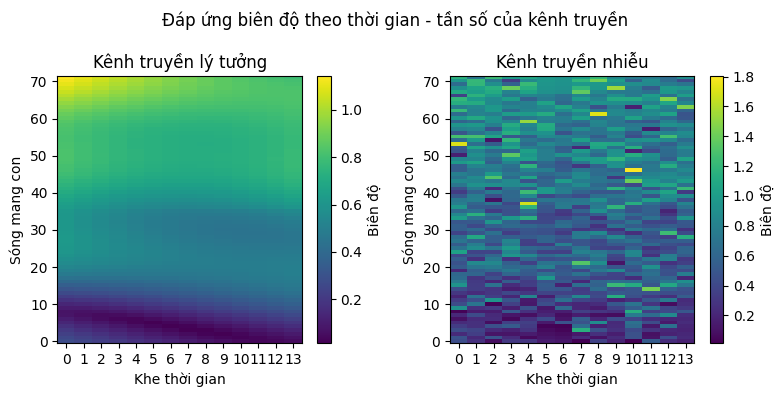

In [4]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
fig.suptitle('Đáp ứng biên độ theo thời gian - tần số của kênh truyền')

# Đáp ứng biên độ của kênh truyền lý tưởng
perfect_response = np.abs(perfect[0].squeeze())
# Đáp ứng biên độ của kênh truyền nhiễu
noisy_response = np.abs(noisy[0].squeeze())

# Vẽ đáp ứng
cax = axes[0].imshow(perfect_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[0].set_title('Kênh truyền lý tưởng')
cax = axes[1].imshow(noisy_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[1].set_title('Kênh truyền nhiễu')

for ax in axes:
    ax.set_ylabel('Sóng mang con')
    ax.set_xlabel('Khe thời gian')
    ax.set_xticks(np.arange(0, n_slots, step=1))
    ax.set_yticks(np.arange(0, n_subs, step=10))

plt.tight_layout()
plt.show()

## Cấu trúc sắp xếp pilot

Số lượng pilot ảnh hưởng đến dữ liệu nội suy kênh nhiễu, mà kênh nhiễu là ngõ vào của mô hình máy học. 

Do đó, ứng với số lượng pilot khác nhau, ta cũng có một tập dữ liệu huấn luyện và một mạng neuron tối ưu riêng.

Số lượng pilot được chọn tiêu biểu từ tập {8, 16, 24, 36, 48}

In [5]:
n_pilots

48

In [6]:
if n_pilots == 48:
    idx = [14 * i for i in range(1, 72, 6)] + [4 + 14 * i for i in range(4, 72, 6)] + \
            [7 + 14 * i for i in range(1, 72, 6)] + [11 + 14 * i for i in range(4, 72, 6)]
elif n_pilots == 16:
    idx = [4 + 14 * i for i in range(1, 72, 9)] + [9 + 14 * i for i in range(4, 72, 9)]
elif n_pilots == 24:
    idx = [14 * i for i in range(1, 72, 9)] + [6 + 14 * i for i in range(4, 72, 9)] + [11 + 14 * i for i in
                                                                                        range(1, 72, 9)]
elif n_pilots == 8:
    idx = [4 + 14 * i for i in range(5, 72, 18)] + [9 + 14 * i for i in range(8, 72, 18)]
elif n_pilots == 36:
    idx = [14 * i for i in range(1, 72, 6)] + [6 + 14 * i for i in range(4, 72, 6)] + [11 + 14 * i for i in
                                                                                        range(1, 72, 6)]
P = np.zeros(n_slots*n_subs)
for i in idx: P[i] = 5
P.reshape((n_slots, n_subs))
T, F = np.meshgrid(range(1, n_slots+1), range(1, n_subs+1))

r = [x // 14 for x in idx]
c = [x % 14 for x in idx]

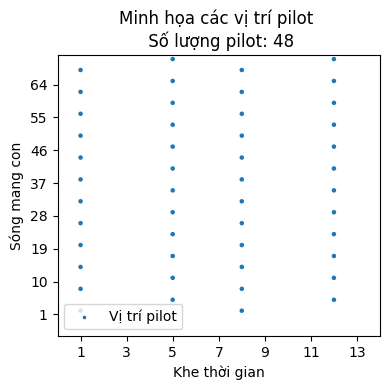

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(T, F, P, label='Vị trí pilot')
ax.legend()
ax.set_title("Minh họa các vị trí pilot \n Số lượng pilot: %d" % n_pilots)

ax.set_xlabel('Khe thời gian')
ax.set_ylabel('Sóng mang con')
ax.set_xlim(0, n_slots)
ax.set_ylim(-5, n_subs)
ax.set_xticks(range(1, n_slots, 2))
ax.set_yticks(range(1, n_subs, 9))

plt.tight_layout()
plt.show()

## Chuẩn bị dữ liệu cho huấn luyện

### 1. Nội suy kênh nhiễu từ pilot và Định dạng kênh nhiễu

In [8]:
noisy_image = np.zeros((n_samples, n_subs, n_slots, 2))

# Tách ảnh thành phần thực và phần ảo
noisy_image[:, :, :, 0] = np.real(noisy)
noisy_image[:, :, :, 1] = np.imag(noisy)

interp_noisy = np.zeros((n_samples, n_subs, n_slots, 2))

for i in range(len(noisy)):
    # Nội suy phần thực
    z = [noisy_image[i, j, k, 0] for j, k in zip(r, c)]
    f = interpolate.Rbf(np.array(r).astype(float), np.array(c).astype(float), z, function='gaussian')
    X, Y = np.meshgrid(range(n_subs), range(n_slots))
    z_intp = f(X, Y)
    interp_noisy[i, :, :, 0] = z_intp.T

    # Nội suy phần ảo
    z = [noisy_image[i, j, k, 1] for j, k in zip(r, c)]
    f = interpolate.Rbf(np.array(r).astype(float), np.array(c).astype(float), z, function='gaussian')
    X, Y = np.meshgrid(range(n_subs), range(n_slots))
    z_intp = f(X, Y)
    interp_noisy[i, :, :, 1] = z_intp.T

interp_noisy = np.concatenate((interp_noisy[:, :, :, 0], 
                               interp_noisy[:, :, :, 1]), axis=0).reshape(2*n_samples, n_subs, n_slots, 1)

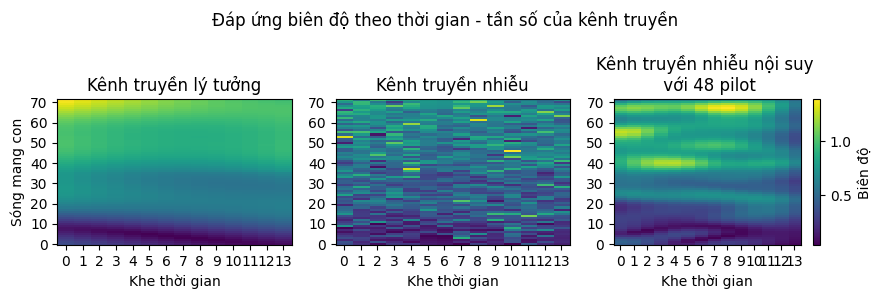

In [9]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(9, 3)
fig.suptitle('Đáp ứng biên độ theo thời gian - tần số của kênh truyền')


# Đáp ứng biên độ của kênh truyền lý tưởng
perfect_response = np.abs(perfect[0].squeeze())
# Đáp ứng biên độ của kênh truyền nhiễu
noisy_response = np.abs(noisy[0].squeeze())
# Đáp ứng biên độ của kênh truyền nhiễu nội suy
noisy_interp_response = interp_noisy[:n_samples, : , :] + 1j*interp_noisy[n_samples:, : , :]
noisy_interp_response = np.abs(noisy_interp_response[0].squeeze())

# Vẽ đáp ứng
cax = axes[0].imshow(perfect_response, aspect='auto', origin='lower', interpolation='none')
axes[0].set_title('Kênh truyền lý tưởng')
axes[0].set_ylabel('Sóng mang con')

cax = axes[1].imshow(noisy_response, aspect='auto', origin='lower', interpolation='none')
axes[1].set_title('Kênh truyền nhiễu')

cax = axes[2].imshow(noisy_interp_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[2].set_title(f"Kênh truyền nhiễu nội suy \n với {n_pilots} pilot")

for ax in axes:
    ax.set_xlabel('Khe thời gian')
    ax.set_xticks(np.arange(0, n_slots, step=1))
    ax.set_yticks(np.arange(0, n_subs, step=10))

plt.tight_layout()
plt.show()

### 2. Định dạng dữ liệu kênh lý tưởng

In [10]:
perfect_image = np.zeros((n_samples, n_subs, n_slots, 2))
perfect_image[:, :, :, 0] = np.real(perfect)
perfect_image[:, :, :, 1] = np.imag(perfect)
perfect_image = np.concatenate((perfect_image[:, :, :, 0], 
                                perfect_image[:, :, :, 1]), axis=0)
perfect_image = perfect_image.reshape(2*n_samples, n_subs, n_slots, 1)

In [11]:
path = "../data/images_" + channel_model \
    + "_" + str(n_pilots) \
    + "_" + str(snr) \
    + "_" + str(n_samples) + ".mat"
savemat(path, {'interp_noisy': interp_noisy, 'perfect_image': perfect_image})

### 3. Chia tập huấn luyện và kiểm tra

In [12]:
print(f"Channel model: {channel_model}")
print(f"Number of pilots: {n_pilots}")
print(f"SNR: {snr}")
print(f"Number of samples: {n_samples}")

path = "../data/images_" + channel_model \
    + "_" + str(n_pilots) \
    + "_" + str(snr) \
    + "_" + str(n_samples) + ".mat"
interp_noisy = loadmat(path)['interp_noisy']
perfect_image = loadmat(path)['perfect_image']

Channel model: VehA
Number of pilots: 48
SNR: 12
Number of samples: 10000


In [13]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_label, val_label = \
    train_test_split(interp_noisy, perfect_image, test_size=0.2)

print(train_data.shape)
print(train_label.shape)
print(val_data.shape)
print(val_label.shape)

(16000, 72, 14, 1)
(16000, 72, 14, 1)
(4000, 72, 14, 1)
(4000, 72, 14, 1)


## Huấn luyện

Huấn luyện mô hình với tập dữ liệu huấn luyện đã chuẩn bị, với:
- Mô hình kênh truyền Vehicular-A
- Số lượng pilot: 8
- SNR: 12 dB

In [14]:
import models, importlib
importlib.reload(models)

models.SRCNN_train(train_data, train_label, val_data, val_label, channel_model, n_pilots, snr, n_samples)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 72, 14, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 72, 14, 64)     │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 14, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 72, 14, 1)      │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1: val_loss improved from inf to 0.01467, saving model to ../trained_nets/SRCNN_check.keras

Epoch 2: val_loss improved from 0.01467 to 0.01178, saving model to ../trained_nets/SRCNN_check.keras

Epoch 3: val_loss improved from 0.01178 to 0.01075, saving model to ../trained_nets/SRCNN_check.keras

Epoch 4: val_loss improved from 0.01075 to 0.01036, saving model to ../trained_nets/SRCNN_check.keras

Epoch 5: val_loss improved from 0.01036 to 0.00965, saving model to ../trained_nets/SRCNN_check.keras

Epoch 6: val_loss improved from 0.00965 to 0.00931, saving model to ../trained_nets/SRCNN_check.keras

Epoch 7: val_loss improved from 0.00931 to 0.00909, saving model to ../trained_nets/SRCNN_check.keras

Epoch 8: val_loss improved from 0.00909 to 0.00901, saving model to ../trained_nets/SRCNN_check.keras

Epoch 9: val_loss improved from 0.00901 to 0.00881, saving model to ../trained_nets/SRCNN_check.keras

Epoch 10: val_loss improved from 0.00881 to 0.00879, saving model to ..

## Kiểm tra mô hình

In [15]:
import models, importlib
importlib.reload(models)

# Từ mô hình đã huấn luyện, ước lượng kênh truyền của tập dữ liệu kiểm tra
srcnn_pred_validation = models.SRCNN_predict(val_data, channel_model, n_pilots, snr, n_samples)

c:\Users\Khanh\miniconda3\envs\tf\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


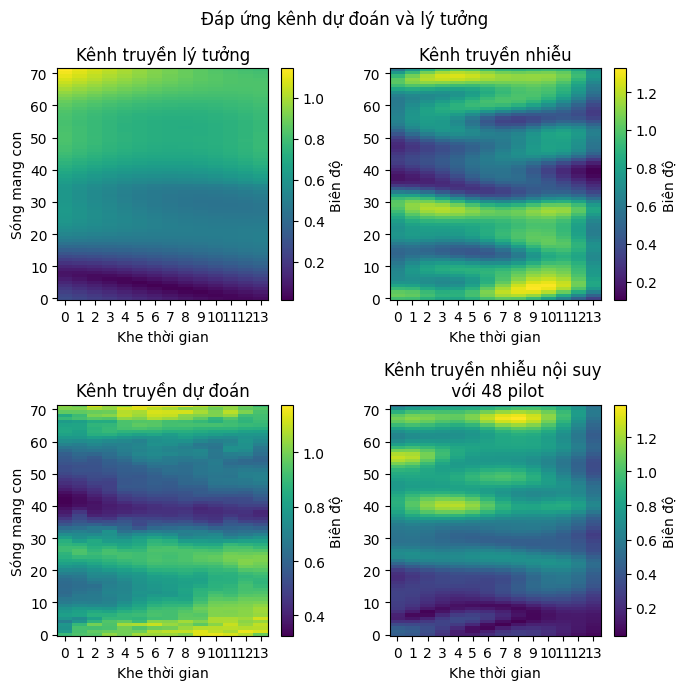

In [16]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(7, 7)
fig.suptitle('Đáp ứng kênh dự đoán và lý tưởng')

# Đáp ứng biên độ của kênh truyền lý tưởng
perfect_response = np.abs(perfect[0].squeeze())
# Đáp ứng biên độ của kênh truyền nhiễu
noisy_response = np.abs(val_data[0].squeeze())
# Đáp ứng biên độ của kênh truyền nhiễu nội suy
noisy_interp_response = interp_noisy[:n_samples, : , :] + 1j*interp_noisy[n_samples:, : , :]
noisy_interp_response = np.abs(noisy_interp_response[0].squeeze())
# Đáp ứng biên độ của kênh truyền dự đoán
pred_response = np.abs(srcnn_pred_validation[0].squeeze())

# Vẽ đáp ứng
cax = axes[0,0].imshow(perfect_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[0,0].set_title('Kênh truyền lý tưởng')
axes[0,0].set_ylabel('Sóng mang con')

cax = axes[0,1].imshow(noisy_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[0,1].set_title('Kênh truyền nhiễu')

cax = axes[1,1].imshow(noisy_interp_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[1,1].set_title(f"Kênh truyền nhiễu nội suy \n với {n_pilots} pilot")

cax = axes[1,0].imshow(pred_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[1,0].set_title('Kênh truyền dự đoán')
axes[1,0].set_ylabel('Sóng mang con')

for ax in axes.ravel():
    ax.set_xlabel('Khe thời gian')
    ax.set_xticks(np.arange(0, n_slots, step=1))
    ax.set_yticks(np.arange(0, n_subs, step=10))

plt.tight_layout()
plt.show()

## Huấn luyện hàng loạt với các giá trị pilot khác nhau

Số lượng pilot ảnh hưởng đến dữ liệu nội suy kênh nhiễu, mà kênh nhiễu là ngõ vào của mô hình máy học. 

Do đó, ứng với số lượng pilot khác nhau, ta cũng có một tập dữ liệu huấn luyện và một mạng neuron tối ưu riêng.

Số lượng pilot được chọn tiêu biểu từ tập {8, 16, 24, 36, 48}

In [17]:
class ChannelInfo:
    def __init__(self, n_pilots):
        self.channel_model  = "VehA"
        self.snr            = 12
        self.n_pilots       = n_pilots
        self.n_samples      = 10000
        self.n_subs         = 72
        self.n_slots        = 14

        self.perfect        = loadmat("../data/Perfect_H_%d.mat" % self.n_samples)['My_perfect_H']
        self.noisy_input    = loadmat("../data/My_noisy_H_%d_%d.mat" % (self.snr, self.n_samples))["My_noisy_H"]

In [20]:
from sklearn.model_selection import train_test_split
from models import interpolation

def channel_net_format_data(channel_info=ChannelInfo):
    perfect         = channel_info.perfect
    noisy_input     = channel_info.noisy_input

    channel_model   = channel_info.channel_model
    snr             = channel_info.snr
    n_pilots        = channel_info.n_pilots
    n_samples       = channel_info.n_samples
    
    n_subs          = channel_info.n_subs
    n_slots         = channel_info.n_slots

    interp_noisy = interpolation(noisy_input, snr, n_pilots, n_samples, 'rbf')

    perfect_image = np.zeros((len(perfect), 72, 14, 2))
    perfect_image[:, :, :, 0] = np.real(perfect)
    perfect_image[:, :, :, 1] = np.imag(perfect)
    perfect_image = np.concatenate((perfect_image[:, :, :, 0], perfect_image[:, :, :, 1]), axis=0)
    perfect_image = perfect_image.reshape(2*n_samples, n_subs, n_slots, 1)

    train_data, val_data, train_label, val_label = \
        train_test_split(interp_noisy, perfect_image, test_size=0.2)

    path = "../data/Validation_%s_%d_%d_%d.mat" % (channel_model, n_pilots, snr, n_samples)
    savemat(path, {'val_data': val_data, 'val_label': val_label})
    return train_data, val_data, train_label, val_label

In [ ]:
import models, importlib
importlib.reload(models)

for n_pilots in [8, 16, 24, 36, 48]:
    channel_info = ChannelInfo(n_pilots)

    channel_model   = channel_info.channel_model
    snr             = channel_info.snr
    n_samples       = channel_info.n_samples
    
    n_subs          = channel_info.n_subs
    n_slots         = channel_info.n_slots

    train_data, val_data, train_label, val_label = channel_net_format_data(channel_info)
    models.SRCNN_train(train_data, train_label, val_data, val_label, 
                       channel_model, n_pilots, snr, n_samples)

## Đánh giá mô hình

c:\Users\Khanh\miniconda3\envs\tf\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


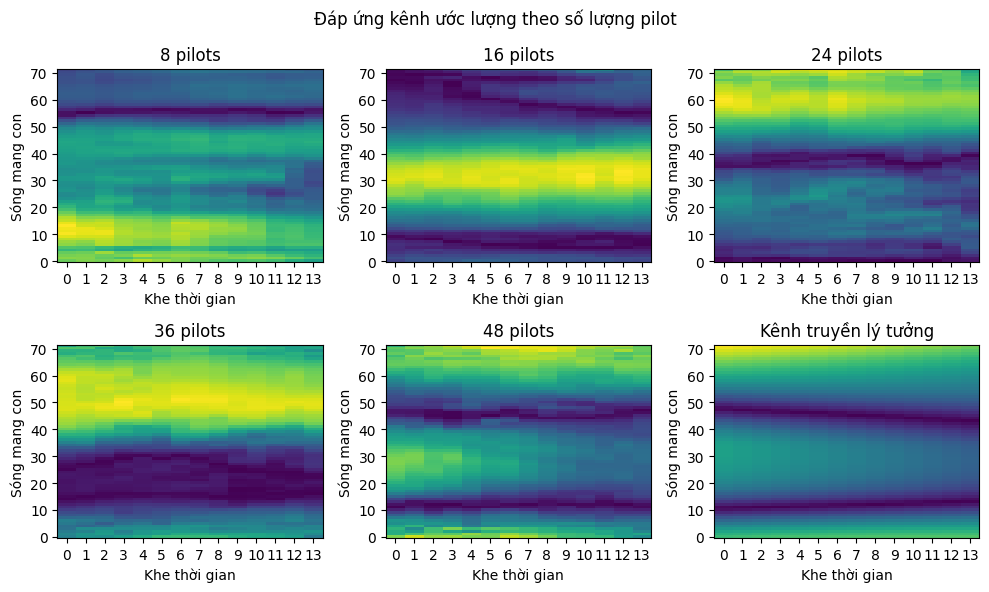

In [23]:
channel_model  = "VehA"
snr            = 12
n_samples      = 10000
n_subs         = 72
n_slots        = 14

fig, axes = plt.subplots(2, 3)
fig.set_size_inches(10, 6)
fig.suptitle('Đáp ứng kênh ước lượng theo số lượng pilot')

n_pilots_list = [8, 16, 24, 36, 48]
ax_id_list = [(0,0), (0,1), (0,2), (1,0), (1,1)]

for (n_pilots, ax_id) in zip(n_pilots_list, ax_id_list):
    path = "../data/Validation_%s_%d_%d_%d.mat" % (channel_model, n_pilots, snr, n_samples)
    val_data = loadmat(path)['val_data']
    val_label = loadmat(path)['val_label']
    val_pred = models.SRCNN_predict(val_data, channel_model, n_pilots, snr, n_samples)

    pred_response = np.abs(val_pred[0].squeeze())
    axes[ax_id].imshow(pred_response, aspect='auto', origin='lower', interpolation='none')
    axes[ax_id].set_title("%d pilots" % n_pilots)

    axes[ax_id].set_ylabel('Sóng mang con')
    axes[ax_id].set_xlabel('Khe thời gian')
    axes[ax_id].set_xticks(np.arange(0, n_slots, step=1))
    axes[ax_id].set_yticks(np.arange(0, n_subs, step=10))

perfect_response = np.abs(val_label[0].squeeze())
axes[1,2].imshow(perfect_response, aspect='auto', origin='lower', interpolation='none')
axes[1,2].set_title('Kênh truyền lý tưởng')

axes[1,2].set_ylabel('Sóng mang con')
axes[1,2].set_xlabel('Khe thời gian')
axes[1,2].set_xticks(np.arange(0, n_slots, step=1))
axes[1,2].set_yticks(np.arange(0, n_subs, step=10))

plt.tight_layout()
plt.show()

In [24]:
import models, importlib
importlib.reload(models)

channel_model  = "VehA"
snr            = 12
n_samples      = 10000
n_subs         = 72
n_slots        = 14

perf_n_pilots   = []
perf_mse        = []

# for n_pilots in [8]:
for n_pilots in [8, 16, 24, 36, 48]:
    path = "../data/Validation_%s_%d_%d_%d.mat" % (channel_model, n_pilots, snr, n_samples)
    val_data = loadmat(path)['val_data']
    val_label = loadmat(path)['val_label']

    val_pred = models.SRCNN_predict(val_data, channel_model, n_pilots, snr, n_samples)
    mse = np.mean((val_pred - val_label)**2)

    perf_n_pilots.append(n_pilots)
    perf_mse.append(mse)

c:\Users\Khanh\miniconda3\envs\tf\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


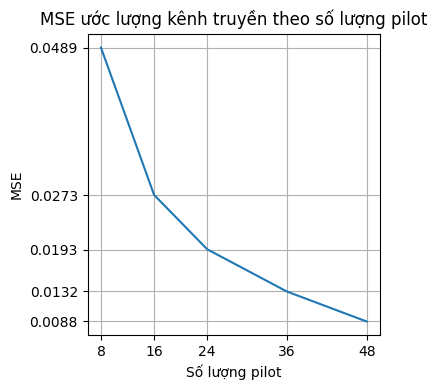

In [30]:
fig, ax = plt.subplots(figsize=(4,4))

ax.plot(perf_n_pilots, perf_mse)
ax.set_title('MSE ước lượng kênh truyền theo số lượng pilot')
ax.set_xticks(perf_n_pilots)
ax.set_yticks(np.round(perf_mse, 4))
ax.set_xlabel('Số lượng pilot')
ax.set_ylabel('MSE')
ax.grid()

plt.tight_layout()
plt.show()

In [29]:
np.round(perf_mse, 4)

array([0.0489, 0.0273, 0.0193, 0.0132, 0.0088])